<a href="https://colab.research.google.com/github/hasol11/Dacos_Datathon/blob/main/%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%86%A42.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

기본 작업

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ijson

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 1.4 MB/s eta 0:00:00


01월달

In [ ]:
import zipfile
import ijson
import pandas as pd

# Zip 파일 경로
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/숙명여대/20230101.zip'

# 삭제할 컬럼 목록
columns_to_drop = ['yyyymmdd', 'ouid', 'age', 'gu', 'url', 'user_time', 'domain', 'media_name', 'media_section', 'search_keyword', 'platform_name']

# 샘플 크기 설정
total_sample_size = 40000
yb_ratio = 0.5  # YB 그룹과 OB 그룹의 비율을 50:50으로 설정
ob_ratio = 1 - yb_ratio

yb_sample_size = int(total_sample_size * yb_ratio)
ob_sample_size = total_sample_size - yb_sample_size

# 샘플을 추출한 행 수를 추적하기 위한 변수
yb_current_sampled = 0
ob_current_sampled = 0

# Zip 파일 열기
with zipfile.ZipFile(zip_file_path, 'r') as z:
    # JSON 파일 추출
    json_file_name = z.namelist()[0]

    with z.open(json_file_name) as file:
        # 데이터를 청크로 나누기 위한 설정
        chunk_size = 100000  # 각 청크당 데이터 개수
        yb_samples = []  # YB 그룹의 샘플을 저장할 리스트
        ob_samples = []  # OB 그룹의 샘플을 저장할 리스트

        # 데이터를 스트리밍으로 읽기
        objects = ijson.items(file, 'item')
        chunk = []

        for i, obj in enumerate(objects):
            chunk.append(obj)

            # 청크 크기에 도달하면 처리
            if (i + 1) % chunk_size == 0:
                print(f"청크 처리 중...")

                # 청크를 DataFrame으로 변환
                df_chunk = pd.DataFrame(chunk)

                # 결측치가 있는 행 제거
                df_chunk = df_chunk.dropna()

                # 필요 없는 컬럼 삭제
                df_chunk = df_chunk.drop(columns=columns_to_drop, errors='ignore')

                # YB 그룹(0-3)과 OB 그룹(4-9)으로 나누기
                yb_group = df_chunk[(df_chunk['age_group'] >= 0) & (df_chunk['age_group'] <= 3)]
                ob_group = df_chunk[(df_chunk['age_group'] >= 4) & (df_chunk['age_group'] <= 9)]

                # YB 그룹에서 층화추출 (남은 샘플 크기만큼만 샘플링)
                if len(yb_group) > 0 and yb_current_sampled < yb_sample_size:
                    yb_sample_chunk_size = min(yb_sample_size - yb_current_sampled, len(yb_group))
                    yb_sample_chunk = yb_group.sample(n=yb_sample_chunk_size, random_state=42)
                    yb_samples.append(yb_sample_chunk)
                    yb_current_sampled += yb_sample_chunk_size

                # OB 그룹에서 층화추출 (남은 샘플 크기만큼만 샘플링)
                if len(ob_group) > 0 and ob_current_sampled < ob_sample_size:
                    ob_sample_chunk_size = min(ob_sample_size - ob_current_sampled, len(ob_group))
                    ob_sample_chunk = ob_group.sample(n=ob_sample_chunk_size, random_state=42)
                    ob_samples.append(ob_sample_chunk)
                    ob_current_sampled += ob_sample_chunk_size

                # 메모리에서 청크 비우기
                chunk = []

                # YB와 OB 그룹의 샘플이 모두 완성되면 중단
                if yb_current_sampled >= yb_sample_size and ob_current_sampled >= ob_sample_size:
                    break

        # 마지막 청크가 남아있으면 처리
        if chunk and (yb_current_sampled < yb_sample_size or ob_current_sampled < ob_sample_size):
            print(f"마지막 청크 처리 중...")
            df_chunk = pd.DataFrame(chunk)

            # 결측치가 있는 행 제거
            df_chunk = df_chunk.dropna()

            # 필요 없는 컬럼 삭제
            df_chunk = df_chunk.drop(columns=columns_to_drop, errors='ignore')

            yb_group = df_chunk[(df_chunk['age_group'] >= 0) & (df_chunk['age_group'] <= 3)]
            ob_group = df_chunk[(df_chunk['age_group'] >= 4) & (df_chunk['age_group'] <= 9)]

            if len(yb_group) > 0 and yb_current_sampled < yb_sample_size:
                yb_sample_chunk_size = min(yb_sample_size - yb_current_sampled, len(yb_group))
                yb_sample_chunk = yb_group.sample(n=yb_sample_chunk_size, random_state=42)
                yb_samples.append(yb_sample_chunk)
                yb_current_sampled += yb_sample_chunk_size

            if len(ob_group) > 0 and ob_current_sampled < ob_sample_size:
                ob_sample_chunk_size = min(ob_sample_size - ob_current_sampled, len(ob_group))
                ob_sample_chunk = ob_group.sample(n=ob_sample_chunk_size, random_state=42)
                ob_samples.append(ob_sample_chunk)
                ob_current_sampled += ob_sample_chunk_size

청크 처리 중...


In [ ]:
        # YB 및 OB 샘플들을 합치기
        yb_samples_df = pd.concat(yb_samples, ignore_index=True)
        ob_samples_df = pd.concat(ob_samples, ignore_index=True)

        # age_group 값 변경 (0~3 -> 1, 4~9 -> 2)
        yb_samples_df['age_group'] = 1
        ob_samples_df['age_group'] = 2

        # 두 그룹 샘플을 합쳐서 최종 샘플링 결과 생성
        sample_result01 = pd.concat([yb_samples_df, ob_samples_df], ignore_index=True)

        print(f"YB 샘플 수: {len(yb_samples_df)}, OB 샘플 수: {len(ob_samples_df)}")
        print(f"최종 샘플링된 데이터 수: {len(sample_result1)}")
        print(sample_result1.head())

        # 결과를 CSV로 저장 (불필요한 컬럼 제거 후)
        sample_result01.to_csv('sample_result01.csv', index=False)


YB 샘플 수: 20000, OB 샘플 수: 20000
최종 샘플링된 데이터 수: 40000
   gender  age_group  job_type city  duration  \
0     2.0        3.0         4   울산        29   
1     1.0        3.0         1   대구       425   
2     2.0        2.0         3   제주        26   
3     1.0        3.0         3   서울        24   
4     1.0        3.0         1   대전        38   

                                       crawled_title  
0                               핸즈커피 디카페인 : 네이버 통합검색  
1      에펨코리아 모바일 - 유머, 축구, 아프리카TV, 게임, 풋볼매니저, 에펨, 펨코  
2  정용화&전현무 목발로 사용하는 혜리 (Jung Yong Hwa, Hyeri, Jeo...  
3                              금호설악리조트 일출 : 네이버 통합검색  
4                                       역정보 - 대전교통공사  


In [ ]:
import pandas as pd
df01=pd.read_csv('sample_result01.csv')
df_processed01= df01['duration']>=25
df_processed01

import pandas as pd

df01 = pd.read_csv('sample_result01.csv')

df_processed01 = df01[df01['duration'] >= 25]

# print(df_processed01)
# processed_01.to_csv('processed_01', index=False)

# 필터링된 데이터를 새로운 CSV 파일로 저장
df_processed01.to_csv('processed_01.csv', index=False)

readpr01=pd.read_csv('processed_01.csv')
readpr01


,gender,age_group,job_type,city,duration,crawled_title
0,2.0,1,4,울산,29,핸즈커피 디카페인 : 네이버 통합검색
1,1.0,1,1,대구,425,"에펨코리아 모바일 - 유머, 축구, 아프리카TV, 게임, 풋볼매니저, 에펨, 펨코"
2,2.0,1,3,제주,26,"정용화&전현무 목발로 사용하는 혜리 (Jung Yong Hwa, Hyeri, Jeo..."
3,1.0,1,1,대전,38,역정보 - 대전교통공사
4,1.0,1,1,서울,26,YouTube
...,...,...,...,...,...,...
10039,2.0,2,2,대구,75,국악방송 | TV | TV 편성표
10040,1.0,2,1,충북,27,YTN :: 네이버뉴스
10041,2.0,2,4,경남,51,무료나눔을 하기 조심스러워지는 이유.jpg - 유쾌방 - 엽기 혹은 진실 (세상 모...
10042,2.0,2,4,제주,71,"[굿데이카드] 주유 60원/L, 통신/교통 10%, 외식/학원 10% - KB 국민카드"


In [ ]:
import zipfile
import ijson
import pandas as pd

# Zip 파일 경로
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/숙명여대/20230201.zip'

# 삭제할 컬럼 목록
columns_to_drop = ['yyyymmdd', 'ouid', 'age', 'gu', 'url', 'user_time', 'domain', 'media_name', 'media_section', 'search_keyword', 'platform_name']

# 샘플 크기 설정
total_sample_size = 40000
yb_ratio = 0.5  # YB 그룹과 OB 그룹의 비율을 50:50으로 설정
ob_ratio = 1 - yb_ratio

yb_sample_size = int(total_sample_size * yb_ratio)
ob_sample_size = total_sample_size - yb_sample_size

# 샘플을 추출한 행 수를 추적하기 위한 변수
yb_current_sampled = 0
ob_current_sampled = 0

# Zip 파일 열기
with zipfile.ZipFile(zip_file_path, 'r') as z:
    # JSON 파일 추출
    json_file_name = z.namelist()[0]

    with z.open(json_file_name) as file:
        # 데이터를 청크로 나누기 위한 설정
        chunk_size = 100000  # 각 청크당 데이터 개수
        yb_samples = []  # YB 그룹의 샘플을 저장할 리스트
        ob_samples = []  # OB 그룹의 샘플을 저장할 리스트

        # 데이터를 스트리밍으로 읽기
        objects = ijson.items(file, 'item')
        chunk = []

        for i, obj in enumerate(objects):
            chunk.append(obj)

            # 청크 크기에 도달하면 처리
            if (i + 1) % chunk_size == 0:
                print(f"청크 처리 중...")

                # 청크를 DataFrame으로 변환
                df_chunk = pd.DataFrame(chunk)

                # 결측치가 있는 행 제거
                df_chunk = df_chunk.dropna()

                # 필요 없는 컬럼 삭제
                df_chunk = df_chunk.drop(columns=columns_to_drop, errors='ignore')

                # YB 그룹(0-3)과 OB 그룹(4-9)으로 나누기
                yb_group = df_chunk[(df_chunk['age_group'] >= 0) & (df_chunk['age_group'] <= 3)]
                ob_group = df_chunk[(df_chunk['age_group'] >= 4) & (df_chunk['age_group'] <= 9)]

                # YB 그룹에서 층화추출 (남은 샘플 크기만큼만 샘플링)
                if len(yb_group) > 0 and yb_current_sampled < yb_sample_size:
                    yb_sample_chunk_size = min(yb_sample_size - yb_current_sampled, len(yb_group))
                    yb_sample_chunk = yb_group.sample(n=yb_sample_chunk_size, random_state=42)
                    yb_samples.append(yb_sample_chunk)
                    yb_current_sampled += yb_sample_chunk_size

                # OB 그룹에서 층화추출 (남은 샘플 크기만큼만 샘플링)
                if len(ob_group) > 0 and ob_current_sampled < ob_sample_size:
                    ob_sample_chunk_size = min(ob_sample_size - ob_current_sampled, len(ob_group))
                    ob_sample_chunk = ob_group.sample(n=ob_sample_chunk_size, random_state=42)
                    ob_samples.append(ob_sample_chunk)
                    ob_current_sampled += ob_sample_chunk_size

                # 메모리에서 청크 비우기
                chunk = []

                # YB와 OB 그룹의 샘플이 모두 완성되면 중단
                if yb_current_sampled >= yb_sample_size and ob_current_sampled >= ob_sample_size:
                    break

        # 마지막 청크가 남아있으면 처리
        if chunk and (yb_current_sampled < yb_sample_size or ob_current_sampled < ob_sample_size):
            print(f"마지막 청크 처리 중...")
            df_chunk = pd.DataFrame(chunk)

            # 결측치가 있는 행 제거
            df_chunk = df_chunk.dropna()

            # 필요 없는 컬럼 삭제
            df_chunk = df_chunk.drop(columns=columns_to_drop, errors='ignore')

            yb_group = df_chunk[(df_chunk['age_group'] >= 0) & (df_chunk['age_group'] <= 3)]
            ob_group = df_chunk[(df_chunk['age_group'] >= 4) & (df_chunk['age_group'] <= 9)]

            if len(yb_group) > 0 and yb_current_sampled < yb_sample_size:
                yb_sample_chunk_size = min(yb_sample_size - yb_current_sampled, len(yb_group))
                yb_sample_chunk = yb_group.sample(n=yb_sample_chunk_size, random_state=42)
                yb_samples.append(yb_sample_chunk)
                yb_current_sampled += yb_sample_chunk_size

            if len(ob_group) > 0 and ob_current_sampled < ob_sample_size:
                ob_sample_chunk_size = min(ob_sample_size - ob_current_sampled, len(ob_group))
                ob_sample_chunk = ob_group.sample(n=ob_sample_chunk_size, random_state=42)
                ob_samples.append(ob_sample_chunk)
                ob_current_sampled += ob_sample_chunk_size

청크 처리 중...


In [ ]:
        # YB 및 OB 샘플들을 합치기
        yb_samples_df = pd.concat(yb_samples, ignore_index=True)
        ob_samples_df = pd.concat(ob_samples, ignore_index=True)

        # age_group 값 변경 (0~3 -> 1, 4~9 -> 2)
        yb_samples_df['age_group'] = 1
        ob_samples_df['age_group'] = 2

        # 두 그룹 샘플을 합쳐서 최종 샘플링 결과 생성
        sample_result01 = pd.concat([yb_samples_df, ob_samples_df], ignore_index=True)

        print(f"YB 샘플 수: {len(yb_samples_df)}, OB 샘플 수: {len(ob_samples_df)}")
        print(f"최종 샘플링된 데이터 수: {len(sample_result1)}")
        print(sample_result1.head())

        # 결과를 CSV로 저장 (불필요한 컬럼 제거 후)
        sample_result01.to_csv('sample_result02.csv', index=False)


YB 샘플 수: 20000, OB 샘플 수: 20000
최종 샘플링된 데이터 수: 40000
   gender  age_group  job_type city  duration  \
0     2.0        3.0         4   울산        29   
1     1.0        3.0         1   대구       425   
2     2.0        2.0         3   제주        26   
3     1.0        3.0         3   서울        24   
4     1.0        3.0         1   대전        38   

                                       crawled_title  
0                               핸즈커피 디카페인 : 네이버 통합검색  
1      에펨코리아 모바일 - 유머, 축구, 아프리카TV, 게임, 풋볼매니저, 에펨, 펨코  
2  정용화&전현무 목발로 사용하는 혜리 (Jung Yong Hwa, Hyeri, Jeo...  
3                              금호설악리조트 일출 : 네이버 통합검색  
4                                       역정보 - 대전교통공사  


In [ ]:
import pandas as pd
df02=pd.read_csv('sample_result02.csv')
df_processed02= df02['duration']>=25
df_processed02

import pandas as pd

df02 = pd.read_csv('sample_result02.csv')

df_processed02 = df02[df02['duration'] >= 25]

# print(df_processed01)
# processed_01.to_csv('processed_01', index=False)

# 필터링된 데이터를 새로운 CSV 파일로 저장
df_processed02.to_csv('processed_02.csv', index=False)

readpr02=pd.read_csv('processed_02.csv')
readpr02


,gender,age_group,job_type,city,duration,crawled_title
0,2.0,1,1,서울,412,8809265103189 - Google 검색 - Chro
1,1.0,1,2,서울,30,[플로팅공항 반대안] 가덕신공항 매립 시간만 당기면 끝 아닌가요? (주부공항 건설일정
2,2.0,1,2,부산,46,딸기쨈 : 네이버 통합검색
3,2.0,1,1,인천,77,"남은 가래떡, 떡국떡으로 색다르게 즐겨보자! 간식 추천 4 : 네이버 포스트"
4,2.0,1,5,부산,207,라노a) 2/1(수) 아침 - 코코볼과 베이글 : 네이버 카페
...,...,...,...,...,...,...
9721,2.0,2,1,인천,57,미샤 - Daum 검색
9722,2.0,2,1,경기,32,fomc 금리 : 네이버 통합검색
9723,2.0,2,4,경기,687,몸 좀 지지겠다는데 불만 있니?' - YouT
9724,1.0,2,1,경기,33,"[뉴스+] 김기현 ""'김연경 인증샷 논란', 본질에서 벗어나···오해 소지 유감"""


In [ ]:
import zipfile
import ijson
import pandas as pd

# Zip 파일 경로
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/숙명여대/20231201.zip'

# 삭제할 컬럼 목록
columns_to_drop = ['yyyymmdd', 'ouid', 'age', 'gu', 'url', 'user_time', 'domain', 'media_name', 'media_section', 'search_keyword', 'platform_name']

# 샘플 크기 설정
total_sample_size = 40000
yb_ratio = 0.5  # YB 그룹과 OB 그룹의 비율을 50:50으로 설정
ob_ratio = 1 - yb_ratio

yb_sample_size = int(total_sample_size * yb_ratio)
ob_sample_size = total_sample_size - yb_sample_size

# 샘플을 추출한 행 수를 추적하기 위한 변수
yb_current_sampled = 0
ob_current_sampled = 0

# Zip 파일 열기
with zipfile.ZipFile(zip_file_path, 'r') as z:
    # JSON 파일 추출
    json_file_name = z.namelist()[0]

    with z.open(json_file_name) as file:
        # 데이터를 청크로 나누기 위한 설정
        chunk_size = 100000  # 각 청크당 데이터 개수
        yb_samples = []  # YB 그룹의 샘플을 저장할 리스트
        ob_samples = []  # OB 그룹의 샘플을 저장할 리스트

        # 데이터를 스트리밍으로 읽기
        objects = ijson.items(file, 'item')
        chunk = []

        for i, obj in enumerate(objects):
            chunk.append(obj)

            # 청크 크기에 도달하면 처리
            if (i + 1) % chunk_size == 0:
                print(f"청크 처리 중...")

                # 청크를 DataFrame으로 변환
                df_chunk = pd.DataFrame(chunk)

                # 결측치가 있는 행 제거
                df_chunk = df_chunk.dropna()

                # 필요 없는 컬럼 삭제
                df_chunk = df_chunk.drop(columns=columns_to_drop, errors='ignore')

                # YB 그룹(0-3)과 OB 그룹(4-9)으로 나누기
                yb_group = df_chunk[(df_chunk['age_group'] >= 0) & (df_chunk['age_group'] <= 3)]
                ob_group = df_chunk[(df_chunk['age_group'] >= 4) & (df_chunk['age_group'] <= 9)]

                # YB 그룹에서 층화추출 (남은 샘플 크기만큼만 샘플링)
                if len(yb_group) > 0 and yb_current_sampled < yb_sample_size:
                    yb_sample_chunk_size = min(yb_sample_size - yb_current_sampled, len(yb_group))
                    yb_sample_chunk = yb_group.sample(n=yb_sample_chunk_size, random_state=42)
                    yb_samples.append(yb_sample_chunk)
                    yb_current_sampled += yb_sample_chunk_size

                # OB 그룹에서 층화추출 (남은 샘플 크기만큼만 샘플링)
                if len(ob_group) > 0 and ob_current_sampled < ob_sample_size:
                    ob_sample_chunk_size = min(ob_sample_size - ob_current_sampled, len(ob_group))
                    ob_sample_chunk = ob_group.sample(n=ob_sample_chunk_size, random_state=42)
                    ob_samples.append(ob_sample_chunk)
                    ob_current_sampled += ob_sample_chunk_size

                # 메모리에서 청크 비우기
                chunk = []

                # YB와 OB 그룹의 샘플이 모두 완성되면 중단
                if yb_current_sampled >= yb_sample_size and ob_current_sampled >= ob_sample_size:
                    break

        # 마지막 청크가 남아있으면 처리
        if chunk and (yb_current_sampled < yb_sample_size or ob_current_sampled < ob_sample_size):
            print(f"마지막 청크 처리 중...")
            df_chunk = pd.DataFrame(chunk)

            # 결측치가 있는 행 제거
            df_chunk = df_chunk.dropna()

            # 필요 없는 컬럼 삭제
            df_chunk = df_chunk.drop(columns=columns_to_drop, errors='ignore')

            yb_group = df_chunk[(df_chunk['age_group'] >= 0) & (df_chunk['age_group'] <= 3)]
            ob_group = df_chunk[(df_chunk['age_group'] >= 4) & (df_chunk['age_group'] <= 9)]

            if len(yb_group) > 0 and yb_current_sampled < yb_sample_size:
                yb_sample_chunk_size = min(yb_sample_size - yb_current_sampled, len(yb_group))
                yb_sample_chunk = yb_group.sample(n=yb_sample_chunk_size, random_state=42)
                yb_samples.append(yb_sample_chunk)
                yb_current_sampled += yb_sample_chunk_size

            if len(ob_group) > 0 and ob_current_sampled < ob_sample_size:
                ob_sample_chunk_size = min(ob_sample_size - ob_current_sampled, len(ob_group))
                ob_sample_chunk = ob_group.sample(n=ob_sample_chunk_size, random_state=42)
                ob_samples.append(ob_sample_chunk)
                ob_current_sampled += ob_sample_chunk_size

청크 처리 중...


In [ ]:
        # YB 및 OB 샘플들을 합치기
        yb_samples_df = pd.concat(yb_samples, ignore_index=True)
        ob_samples_df = pd.concat(ob_samples, ignore_index=True)

        # age_group 값 변경 (0~3 -> 1, 4~9 -> 2)
        yb_samples_df['age_group'] = 1
        ob_samples_df['age_group'] = 2

        # 두 그룹 샘플을 합쳐서 최종 샘플링 결과 생성
        sample_result01 = pd.concat([yb_samples_df, ob_samples_df], ignore_index=True)

        print(f"YB 샘플 수: {len(yb_samples_df)}, OB 샘플 수: {len(ob_samples_df)}")
        print(f"최종 샘플링된 데이터 수: {len(sample_result1)}")
        print(sample_result1.head())

        # 결과를 CSV로 저장 (불필요한 컬럼 제거 후)
        sample_result01.to_csv('sample_result12.csv', index=False)


YB 샘플 수: 20000, OB 샘플 수: 20000
최종 샘플링된 데이터 수: 40000
   gender  age_group  job_type city  duration  \
0     2.0        3.0         4   울산        29   
1     1.0        3.0         1   대구       425   
2     2.0        2.0         3   제주        26   
3     1.0        3.0         3   서울        24   
4     1.0        3.0         1   대전        38   

                                       crawled_title  
0                               핸즈커피 디카페인 : 네이버 통합검색  
1      에펨코리아 모바일 - 유머, 축구, 아프리카TV, 게임, 풋볼매니저, 에펨, 펨코  
2  정용화&전현무 목발로 사용하는 혜리 (Jung Yong Hwa, Hyeri, Jeo...  
3                              금호설악리조트 일출 : 네이버 통합검색  
4                                       역정보 - 대전교통공사  


In [ ]:
# import pandas as pd
# df03=pd.read_csv('sample_result03.csv')
# df_processed03= df03['duration']>=25
# df_processed03

import pandas as pd

df12 = pd.read_csv('sample_result12.csv')

df_processed12 = df12[df12['duration'] >= 25]

# print(df_processed01)
# processed_01.to_csv('processed_01', index=False)

# 필터링된 데이터를 새로운 CSV 파일로 저장
df_processed12.to_csv('processed_12.csv', index=False)

readpr12=pd.read_csv('processed_12.csv')
readpr12


,gender,age_group,job_type,city,duration,crawled_title
0,2.0,1,5,부산,114,홈플러스 | 홈플대란
1,1.0,1,2,서울,758,10. 모아모아의 지하실 :: 네이버 웹툰
2,2.0,1,0,서울,664,01039966787 : 네이버 통합검색
3,2.0,1,1,인천,169,철물박사 - Ch
4,2.0,1,1,서울,36,네이버 카페
...,...,...,...,...,...,...
9374,2.0,2,1,경기,90,행복의 기준. 성장&노력 : 네이버 블로그
9375,2.0,2,4,대전,35,"엘에스(LS)머트리얼즈 공모주 공모가, 청약 일정, 최소 증거금, 유통물량은? : ..."
9376,2.0,2,1,서울,564,자승스님 : 네이버 통합검색
9377,2.0,2,1,인천,34,NAVER


In [ ]:
import zipfile
import ijson
import pandas as pd

# Zip 파일 경로
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/숙명여대/20230601.zip'

# 삭제할 컬럼 목록
columns_to_drop = ['yyyymmdd', 'ouid', 'age', 'gu', 'url', 'user_time', 'domain', 'media_name', 'media_section', 'search_keyword', 'platform_name']

# 샘플 크기 설정
total_sample_size = 40000
yb_ratio = 0.5  # YB 그룹과 OB 그룹의 비율을 50:50으로 설정
ob_ratio = 1 - yb_ratio

yb_sample_size = int(total_sample_size * yb_ratio)
ob_sample_size = total_sample_size - yb_sample_size

# 샘플을 추출한 행 수를 추적하기 위한 변수
yb_current_sampled = 0
ob_current_sampled = 0

# Zip 파일 열기
with zipfile.ZipFile(zip_file_path, 'r') as z:
    # JSON 파일 추출
    json_file_name = z.namelist()[0]

    with z.open(json_file_name) as file:
        # 데이터를 청크로 나누기 위한 설정
        chunk_size = 100000  # 각 청크당 데이터 개수
        yb_samples = []  # YB 그룹의 샘플을 저장할 리스트
        ob_samples = []  # OB 그룹의 샘플을 저장할 리스트

        # 데이터를 스트리밍으로 읽기
        objects = ijson.items(file, 'item')
        chunk = []

        for i, obj in enumerate(objects):
            chunk.append(obj)

            # 청크 크기에 도달하면 처리
            if (i + 1) % chunk_size == 0:
                print(f"청크 처리 중...")

                # 청크를 DataFrame으로 변환
                df_chunk = pd.DataFrame(chunk)

                # 결측치가 있는 행 제거
                df_chunk = df_chunk.dropna()

                # 필요 없는 컬럼 삭제
                df_chunk = df_chunk.drop(columns=columns_to_drop, errors='ignore')

                # YB 그룹(0-3)과 OB 그룹(4-9)으로 나누기
                yb_group = df_chunk[(df_chunk['age_group'] >= 0) & (df_chunk['age_group'] <= 3)]
                ob_group = df_chunk[(df_chunk['age_group'] >= 4) & (df_chunk['age_group'] <= 9)]

                # YB 그룹에서 층화추출 (남은 샘플 크기만큼만 샘플링)
                if len(yb_group) > 0 and yb_current_sampled < yb_sample_size:
                    yb_sample_chunk_size = min(yb_sample_size - yb_current_sampled, len(yb_group))
                    yb_sample_chunk = yb_group.sample(n=yb_sample_chunk_size, random_state=42)
                    yb_samples.append(yb_sample_chunk)
                    yb_current_sampled += yb_sample_chunk_size

                # OB 그룹에서 층화추출 (남은 샘플 크기만큼만 샘플링)
                if len(ob_group) > 0 and ob_current_sampled < ob_sample_size:
                    ob_sample_chunk_size = min(ob_sample_size - ob_current_sampled, len(ob_group))
                    ob_sample_chunk = ob_group.sample(n=ob_sample_chunk_size, random_state=42)
                    ob_samples.append(ob_sample_chunk)
                    ob_current_sampled += ob_sample_chunk_size

                # 메모리에서 청크 비우기
                chunk = []

                # YB와 OB 그룹의 샘플이 모두 완성되면 중단
                if yb_current_sampled >= yb_sample_size and ob_current_sampled >= ob_sample_size:
                    break

        # 마지막 청크가 남아있으면 처리
        if chunk and (yb_current_sampled < yb_sample_size or ob_current_sampled < ob_sample_size):
            print(f"마지막 청크 처리 중...")
            df_chunk = pd.DataFrame(chunk)

            # 결측치가 있는 행 제거
            df_chunk = df_chunk.dropna()

            # 필요 없는 컬럼 삭제
            df_chunk = df_chunk.drop(columns=columns_to_drop, errors='ignore')

            yb_group = df_chunk[(df_chunk['age_group'] >= 0) & (df_chunk['age_group'] <= 3)]
            ob_group = df_chunk[(df_chunk['age_group'] >= 4) & (df_chunk['age_group'] <= 9)]

            if len(yb_group) > 0 and yb_current_sampled < yb_sample_size:
                yb_sample_chunk_size = min(yb_sample_size - yb_current_sampled, len(yb_group))
                yb_sample_chunk = yb_group.sample(n=yb_sample_chunk_size, random_state=42)
                yb_samples.append(yb_sample_chunk)
                yb_current_sampled += yb_sample_chunk_size

            if len(ob_group) > 0 and ob_current_sampled < ob_sample_size:
                ob_sample_chunk_size = min(ob_sample_size - ob_current_sampled, len(ob_group))
                ob_sample_chunk = ob_group.sample(n=ob_sample_chunk_size, random_state=42)
                ob_samples.append(ob_sample_chunk)
                ob_current_sampled += ob_sample_chunk_size

청크 처리 중...


In [ ]:
        # YB 및 OB 샘플들을 합치기
        yb_samples_df = pd.concat(yb_samples, ignore_index=True)
        ob_samples_df = pd.concat(ob_samples, ignore_index=True)

        # age_group 값 변경 (0~3 -> 1, 4~9 -> 2)
        yb_samples_df['age_group'] = 1
        ob_samples_df['age_group'] = 2

        # 두 그룹 샘플을 합쳐서 최종 샘플링 결과 생성
        sample_result01 = pd.concat([yb_samples_df, ob_samples_df], ignore_index=True)

        print(f"YB 샘플 수: {len(yb_samples_df)}, OB 샘플 수: {len(ob_samples_df)}")
        print(f"최종 샘플링된 데이터 수: {len(sample_result1)}")
        print(sample_result1.head())

        # 결과를 CSV로 저장 (불필요한 컬럼 제거 후)
        sample_result01.to_csv('sample_result06.csv', index=False)


YB 샘플 수: 20000, OB 샘플 수: 20000
최종 샘플링된 데이터 수: 40000
   gender  age_group  job_type city  duration  \
0     2.0        3.0         4   울산        29   
1     1.0        3.0         1   대구       425   
2     2.0        2.0         3   제주        26   
3     1.0        3.0         3   서울        24   
4     1.0        3.0         1   대전        38   

                                       crawled_title  
0                               핸즈커피 디카페인 : 네이버 통합검색  
1      에펨코리아 모바일 - 유머, 축구, 아프리카TV, 게임, 풋볼매니저, 에펨, 펨코  
2  정용화&전현무 목발로 사용하는 혜리 (Jung Yong Hwa, Hyeri, Jeo...  
3                              금호설악리조트 일출 : 네이버 통합검색  
4                                       역정보 - 대전교통공사  


In [ ]:
import pandas as pd

df06 = pd.read_csv('sample_result06.csv')

df_processed06 = df06[df06['duration'] >= 25]

# 필터링된 데이터를 새로운 CSV 파일로 저장
df_processed06.to_csv('processed_06.csv', index=False)

readpr06=pd.read_csv('processed_06.csv')
readpr06


,gender,age_group,job_type,city,duration,crawled_title
0,1.0,1,3,서울,953,승부조작에 휘말린 야구계? 용과같이5 【 4부 시나다 타츠오 】 - YouTube ...
1,1.0,1,1,서울,26,리벨리온 - Ch
2,2.0,1,0,인천,585,캘리퍼까지 교환하게 되면 금액 : 네이버 지식iN
3,2.0,1,1,경기,408,HOT - CCTV에 찍힌 정유정
4,2.0,1,1,경북,260,대구아이와가볼만한곳 - 동성로 스파크랜드 키즈존(10세까지) : 네이버 블로그
...,...,...,...,...,...,...
9032,2.0,2,1,경기,38,[속보] ‘병역법 위반’ 축구 국가대표 출신 석현준 1심 집행유예
9033,2.0,2,4,대구,61,우주까지 가서 태양광 발전을 하는 이유 - YouTube - 오디오 재생
9034,2.0,2,1,서울,36,어제 경기 노잼답게 시청률 망했네 - 골 때리는 그녀들 마이너 갤러리
9035,1.0,2,1,경기,40,아이비리그 대학교 카페 - YouTube


In [ ]:
import zipfile
import ijson
import pandas as pd

# Zip 파일 경로
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/숙명여대/20230701.zip'

# 삭제할 컬럼 목록
columns_to_drop = ['yyyymmdd', 'ouid', 'age', 'gu', 'url', 'user_time', 'domain', 'media_name', 'media_section', 'search_keyword', 'platform_name']

# 샘플 크기 설정
total_sample_size = 40000
yb_ratio = 0.5  # YB 그룹과 OB 그룹의 비율을 50:50으로 설정
ob_ratio = 1 - yb_ratio

yb_sample_size = int(total_sample_size * yb_ratio)
ob_sample_size = total_sample_size - yb_sample_size

# 샘플을 추출한 행 수를 추적하기 위한 변수
yb_current_sampled = 0
ob_current_sampled = 0

# Zip 파일 열기
with zipfile.ZipFile(zip_file_path, 'r') as z:
    # JSON 파일 추출
    json_file_name = z.namelist()[0]

    with z.open(json_file_name) as file:
        # 데이터를 청크로 나누기 위한 설정
        chunk_size = 100000  # 각 청크당 데이터 개수
        yb_samples = []  # YB 그룹의 샘플을 저장할 리스트
        ob_samples = []  # OB 그룹의 샘플을 저장할 리스트

        # 데이터를 스트리밍으로 읽기
        objects = ijson.items(file, 'item')
        chunk = []

        for i, obj in enumerate(objects):
            chunk.append(obj)

            # 청크 크기에 도달하면 처리
            if (i + 1) % chunk_size == 0:
                print(f"청크 처리 중...")

                # 청크를 DataFrame으로 변환
                df_chunk = pd.DataFrame(chunk)

                # 결측치가 있는 행 제거
                df_chunk = df_chunk.dropna()

                # 필요 없는 컬럼 삭제
                df_chunk = df_chunk.drop(columns=columns_to_drop, errors='ignore')

                # YB 그룹(0-3)과 OB 그룹(4-9)으로 나누기
                yb_group = df_chunk[(df_chunk['age_group'] >= 0) & (df_chunk['age_group'] <= 3)]
                ob_group = df_chunk[(df_chunk['age_group'] >= 4) & (df_chunk['age_group'] <= 9)]

                # YB 그룹에서 층화추출 (남은 샘플 크기만큼만 샘플링)
                if len(yb_group) > 0 and yb_current_sampled < yb_sample_size:
                    yb_sample_chunk_size = min(yb_sample_size - yb_current_sampled, len(yb_group))
                    yb_sample_chunk = yb_group.sample(n=yb_sample_chunk_size, random_state=42)
                    yb_samples.append(yb_sample_chunk)
                    yb_current_sampled += yb_sample_chunk_size

                # OB 그룹에서 층화추출 (남은 샘플 크기만큼만 샘플링)
                if len(ob_group) > 0 and ob_current_sampled < ob_sample_size:
                    ob_sample_chunk_size = min(ob_sample_size - ob_current_sampled, len(ob_group))
                    ob_sample_chunk = ob_group.sample(n=ob_sample_chunk_size, random_state=42)
                    ob_samples.append(ob_sample_chunk)
                    ob_current_sampled += ob_sample_chunk_size

                # 메모리에서 청크 비우기
                chunk = []

                # YB와 OB 그룹의 샘플이 모두 완성되면 중단
                if yb_current_sampled >= yb_sample_size and ob_current_sampled >= ob_sample_size:
                    break

        # 마지막 청크가 남아있으면 처리
        if chunk and (yb_current_sampled < yb_sample_size or ob_current_sampled < ob_sample_size):
            print(f"마지막 청크 처리 중...")
            df_chunk = pd.DataFrame(chunk)

            # 결측치가 있는 행 제거
            df_chunk = df_chunk.dropna()

            # 필요 없는 컬럼 삭제
            df_chunk = df_chunk.drop(columns=columns_to_drop, errors='ignore')

            yb_group = df_chunk[(df_chunk['age_group'] >= 0) & (df_chunk['age_group'] <= 3)]
            ob_group = df_chunk[(df_chunk['age_group'] >= 4) & (df_chunk['age_group'] <= 9)]

            if len(yb_group) > 0 and yb_current_sampled < yb_sample_size:
                yb_sample_chunk_size = min(yb_sample_size - yb_current_sampled, len(yb_group))
                yb_sample_chunk = yb_group.sample(n=yb_sample_chunk_size, random_state=42)
                yb_samples.append(yb_sample_chunk)
                yb_current_sampled += yb_sample_chunk_size

            if len(ob_group) > 0 and ob_current_sampled < ob_sample_size:
                ob_sample_chunk_size = min(ob_sample_size - ob_current_sampled, len(ob_group))
                ob_sample_chunk = ob_group.sample(n=ob_sample_chunk_size, random_state=42)
                ob_samples.append(ob_sample_chunk)
                ob_current_sampled += ob_sample_chunk_size

청크 처리 중...


In [ ]:
        # YB 및 OB 샘플들을 합치기
        yb_samples_df = pd.concat(yb_samples, ignore_index=True)
        ob_samples_df = pd.concat(ob_samples, ignore_index=True)

        # age_group 값 변경 (0~3 -> 1, 4~9 -> 2)
        yb_samples_df['age_group'] = 1
        ob_samples_df['age_group'] = 2

        # 두 그룹 샘플을 합쳐서 최종 샘플링 결과 생성
        sample_result01 = pd.concat([yb_samples_df, ob_samples_df], ignore_index=True)

        print(f"YB 샘플 수: {len(yb_samples_df)}, OB 샘플 수: {len(ob_samples_df)}")
        print(f"최종 샘플링된 데이터 수: {len(sample_result1)}")
        print(sample_result1.head())

        # 결과를 CSV로 저장 (불필요한 컬럼 제거 후)
        sample_result01.to_csv('sample_result07.csv', index=False)


YB 샘플 수: 20000, OB 샘플 수: 20000
최종 샘플링된 데이터 수: 40000
   gender  age_group  job_type city  duration  \
0     2.0        3.0         4   울산        29   
1     1.0        3.0         1   대구       425   
2     2.0        2.0         3   제주        26   
3     1.0        3.0         3   서울        24   
4     1.0        3.0         1   대전        38   

                                       crawled_title  
0                               핸즈커피 디카페인 : 네이버 통합검색  
1      에펨코리아 모바일 - 유머, 축구, 아프리카TV, 게임, 풋볼매니저, 에펨, 펨코  
2  정용화&전현무 목발로 사용하는 혜리 (Jung Yong Hwa, Hyeri, Jeo...  
3                              금호설악리조트 일출 : 네이버 통합검색  
4                                       역정보 - 대전교통공사  


In [ ]:
import pandas as pd

df07 = pd.read_csv('sample_result07.csv')

df_processed07 = df07[df07['duration'] >= 25]

# 필터링된 데이터를 새로운 CSV 파일로 저장
df_processed07.to_csv('processed_07.csv', index=False)

readpr7=pd.read_csv('processed_07.csv')
readpr7


,gender,age_group,job_type,city,duration,crawled_title
0,2.0,1,5,부산,25,"[smartel] 스위트 7GB+ | 0원 | 모요, 모두의요금제"
1,1.0,1,1,서울,40,아리에스터 감독 싸인 : 네이버 VIEW
2,1.0,1,1,대구,40,"[오피셜] '득점 갈증' 강원, 99년생 ST 야고 영입 - 포텐 터짐 최신순 - ..."
3,2.0,1,4,서울,75,고메스퀘어 수유 뷔페 추천 쿠우쿠우와 차이점은?(ft. 놀이방 식당) : 네이버 블로그
4,1.0,1,1,경기,445,호랑이 떡볶이와 프랜차이즈 창업비용 줄이자! : 네이버 블로그
...,...,...,...,...,...,...
9837,1.0,2,1,경기,231,‘101이닝 페이스’ 임기영 쓰고도 6월 5승7패… KIA가 뭔가 잘못되고 있다는 증거
9838,1.0,2,1,서울,834,야구 | 다음스포츠
9839,2.0,2,4,광주,32,꽃담 : 네이버 통합검색
9840,2.0,2,4,대구,113,파일마루 - Ch


In [ ]:
import zipfile
import ijson
import pandas as pd

# Zip 파일 경로
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/숙명여대/20230801.zip'

# 삭제할 컬럼 목록
columns_to_drop = ['yyyymmdd', 'ouid', 'age', 'gu', 'url', 'user_time', 'domain', 'media_name', 'media_section', 'search_keyword', 'platform_name']

# 샘플 크기 설정
total_sample_size = 40000
yb_ratio = 0.5  # YB 그룹과 OB 그룹의 비율을 50:50으로 설정
ob_ratio = 1 - yb_ratio

yb_sample_size = int(total_sample_size * yb_ratio)
ob_sample_size = total_sample_size - yb_sample_size

# 샘플을 추출한 행 수를 추적하기 위한 변수
yb_current_sampled = 0
ob_current_sampled = 0

# Zip 파일 열기
with zipfile.ZipFile(zip_file_path, 'r') as z:
    # JSON 파일 추출
    json_file_name = z.namelist()[0]

    with z.open(json_file_name) as file:
        # 데이터를 청크로 나누기 위한 설정
        chunk_size = 100000  # 각 청크당 데이터 개수
        yb_samples = []  # YB 그룹의 샘플을 저장할 리스트
        ob_samples = []  # OB 그룹의 샘플을 저장할 리스트

        # 데이터를 스트리밍으로 읽기
        objects = ijson.items(file, 'item')
        chunk = []

        for i, obj in enumerate(objects):
            chunk.append(obj)

            # 청크 크기에 도달하면 처리
            if (i + 1) % chunk_size == 0:
                print(f"청크 처리 중...")

                # 청크를 DataFrame으로 변환
                df_chunk = pd.DataFrame(chunk)

                # 결측치가 있는 행 제거
                df_chunk = df_chunk.dropna()

                # 필요 없는 컬럼 삭제
                df_chunk = df_chunk.drop(columns=columns_to_drop, errors='ignore')

                # YB 그룹(0-3)과 OB 그룹(4-9)으로 나누기
                yb_group = df_chunk[(df_chunk['age_group'] >= 0) & (df_chunk['age_group'] <= 3)]
                ob_group = df_chunk[(df_chunk['age_group'] >= 4) & (df_chunk['age_group'] <= 9)]

                # YB 그룹에서 층화추출 (남은 샘플 크기만큼만 샘플링)
                if len(yb_group) > 0 and yb_current_sampled < yb_sample_size:
                    yb_sample_chunk_size = min(yb_sample_size - yb_current_sampled, len(yb_group))
                    yb_sample_chunk = yb_group.sample(n=yb_sample_chunk_size, random_state=42)
                    yb_samples.append(yb_sample_chunk)
                    yb_current_sampled += yb_sample_chunk_size

                # OB 그룹에서 층화추출 (남은 샘플 크기만큼만 샘플링)
                if len(ob_group) > 0 and ob_current_sampled < ob_sample_size:
                    ob_sample_chunk_size = min(ob_sample_size - ob_current_sampled, len(ob_group))
                    ob_sample_chunk = ob_group.sample(n=ob_sample_chunk_size, random_state=42)
                    ob_samples.append(ob_sample_chunk)
                    ob_current_sampled += ob_sample_chunk_size

                # 메모리에서 청크 비우기
                chunk = []

                # YB와 OB 그룹의 샘플이 모두 완성되면 중단
                if yb_current_sampled >= yb_sample_size and ob_current_sampled >= ob_sample_size:
                    break

        # 마지막 청크가 남아있으면 처리
        if chunk and (yb_current_sampled < yb_sample_size or ob_current_sampled < ob_sample_size):
            print(f"마지막 청크 처리 중...")
            df_chunk = pd.DataFrame(chunk)

            # 결측치가 있는 행 제거
            df_chunk = df_chunk.dropna()

            # 필요 없는 컬럼 삭제
            df_chunk = df_chunk.drop(columns=columns_to_drop, errors='ignore')

            yb_group = df_chunk[(df_chunk['age_group'] >= 0) & (df_chunk['age_group'] <= 3)]
            ob_group = df_chunk[(df_chunk['age_group'] >= 4) & (df_chunk['age_group'] <= 9)]

            if len(yb_group) > 0 and yb_current_sampled < yb_sample_size:
                yb_sample_chunk_size = min(yb_sample_size - yb_current_sampled, len(yb_group))
                yb_sample_chunk = yb_group.sample(n=yb_sample_chunk_size, random_state=42)
                yb_samples.append(yb_sample_chunk)
                yb_current_sampled += yb_sample_chunk_size

            if len(ob_group) > 0 and ob_current_sampled < ob_sample_size:
                ob_sample_chunk_size = min(ob_sample_size - ob_current_sampled, len(ob_group))
                ob_sample_chunk = ob_group.sample(n=ob_sample_chunk_size, random_state=42)
                ob_samples.append(ob_sample_chunk)
                ob_current_sampled += ob_sample_chunk_size

청크 처리 중...


In [ ]:
        # YB 및 OB 샘플들을 합치기
        yb_samples_df = pd.concat(yb_samples, ignore_index=True)
        ob_samples_df = pd.concat(ob_samples, ignore_index=True)

        # age_group 값 변경 (0~3 -> 1, 4~9 -> 2)
        yb_samples_df['age_group'] = 1
        ob_samples_df['age_group'] = 2

        # 두 그룹 샘플을 합쳐서 최종 샘플링 결과 생성
        sample_result01 = pd.concat([yb_samples_df, ob_samples_df], ignore_index=True)

        print(f"YB 샘플 수: {len(yb_samples_df)}, OB 샘플 수: {len(ob_samples_df)}")
        print(f"최종 샘플링된 데이터 수: {len(sample_result1)}")
        print(sample_result1.head())

        # 결과를 CSV로 저장 (불필요한 컬럼 제거 후)
        sample_result01.to_csv('sample_result08.csv', index=False)


YB 샘플 수: 20000, OB 샘플 수: 20000
최종 샘플링된 데이터 수: 40000
   gender  age_group  job_type city  duration  \
0     2.0        3.0         4   울산        29   
1     1.0        3.0         1   대구       425   
2     2.0        2.0         3   제주        26   
3     1.0        3.0         3   서울        24   
4     1.0        3.0         1   대전        38   

                                       crawled_title  
0                               핸즈커피 디카페인 : 네이버 통합검색  
1      에펨코리아 모바일 - 유머, 축구, 아프리카TV, 게임, 풋볼매니저, 에펨, 펨코  
2  정용화&전현무 목발로 사용하는 혜리 (Jung Yong Hwa, Hyeri, Jeo...  
3                              금호설악리조트 일출 : 네이버 통합검색  
4                                       역정보 - 대전교통공사  


In [ ]:
import pandas as pd

df08 = pd.read_csv('sample_result08.csv')

df_processed08 = df08[df08['duration'] >= 25]

# 필터링된 데이터를 새로운 CSV 파일로 저장
df_processed08.to_csv('processed_08.csv', index=False)

readpr8=pd.read_csv('processed_08.csv')
readpr8


,gender,age_group,job_type,city,duration,crawled_title
0,2.0,1,5,부산,289,"○ 카카오페이방,월급쟁이 재테크 연구카페(예금,적금,펀드,보험,CMA,주식,경매) ..."
1,2.0,1,1,인천,90,아레나 누드브라 소프트 하드 볼륨누드브라 수영복 실리콘브라캡
2,1.0,1,1,대전,27,"here we go! ""강력한 9번 공격수"" 에릭센이 인증한 1180억원 '제2 홀란드'"
3,2.0,1,5,경기,226,si설계사무소 : 네이버 통합검색
4,1.0,1,3,경기,27,네이버 스포츠
...,...,...,...,...,...,...
9557,2.0,2,0,경기,62,"생식만 하던 30대 인플루언서, 결국 사망…‘아사’ 의심"
9558,2.0,2,2,광주,46,‘이 증상’ 느껴지면 살 빠지고 있다는 신호
9559,2.0,2,1,서울,61,소울드레서 (SoulDresser) - Daum 카페 -
9560,2.0,2,4,서울,213,토스 용돈뿌리기 : 네이버 VIEW


In [ ]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 17.1 MB/s eta 0:00:00


In [ ]:
import re
import pandas as pd
from konlpy.tag import Okt

# 불필요한 사이트명 패턴 정의
def remove_site_names(title):
    pattern = r"(네이버|연합뉴스|나무위키|플레이스|블로그|카페|통합검색|Daum|VIEW|검색)"
    return re.sub(pattern, '', title).strip()

def remove_special_chars(text):
    return re.sub(r"[^\w\s]", '', text)

# 영어만 있는 제목을 확인하는 함수
def is_english_only(title):
    return bool(re.fullmatch(r'[A-Za-z\s]+', title))  # 영어와 공백만 포함된 경우 True 반환

# 영어만 있는 행을 필터링하여 제거
readpr8 = readpr8[~readpr8['crawled_title'].apply(is_english_only)]

# 이미 존재하는 df03이 있다고 가정하고 ['crawled_title'] 열에 함수 적용
readpr8['crawled_title'] = readpr8['crawled_title'].apply(remove_site_names)

readpr8['crawled_title'] = readpr8['crawled_title'].apply(remove_special_chars)

from konlpy.tag import Okt

# 불용어 목록 정의
stopwords = ['그리고', '하지만', '그러나', '때문에', '또한', '이제', '이것', '저것', '그것', '에서']

# Okt 형태소 분석기 초기화
okt = Okt()

# 불용어 제거 함수 정의
def remove_stopwords(text):
    # 형태소 분석을 통해 단어 추출
    words = okt.morphs(text)
    # 불용어 목록에 포함되지 않은 단어만 남기기
    return ' '.join([word for word in words if word not in stopwords])

readpr8['crawled_title'] = readpr8['crawled_title'].apply(remove_stopwords)



# Okt 형태소 분석기 초기화
okt = Okt()


# 조사 제거 및 토큰화 함수 정의
def tokenize_and_remove_josa(text):
    tokens = okt.pos(text)  # 형태소와 품사 태그 분석
    # 'Josa' 태그가 아닌 것만 선택
    filtered_tokens = [word for word, pos in tokens if pos != 'Josa']
    return filtered_tokens

# 'readpr8' 데이터프레임의 'crawled_title' 열에 토큰화 및 조사 제거 적용
readpr8['tokens'] = readpr8['crawled_title'].apply(tokenize_and_remove_josa)

# 필터링된 데이터를 새로운 CSV 파일로 저장
readpr8.to_csv('final_08.csv', index=False)


readpr8


,gender,age_group,job_type,city,duration,crawled_title,tokens
0,2.0,1,5,부산,289,카카오 페이 방 월급쟁이 재테크 연구 예금 적금 펀드 보험 CMA 주식 경매,"[카카오, 페이, 방, 월급쟁이, 재테크, 연구, 예금, 적금, 펀드, 보험, CM..."
1,2.0,1,1,인천,90,아레나 누드 브라 소프트 하드 볼륨 누드 브라 수영복 실리콘 브라 캡,"[아레나, 누드, 브라, 소프트, 하드, 볼륨, 누드, 브라, 수영복, 실리콘, 브..."
2,1.0,1,1,대전,27,here we go 강력한 9 번 공격수 에릭 센이 인증 한 1180억원 제 2 홀란드,"[here, we, go, 강력한, 9, 번, 공격수, 에릭, 센이, 인증, 한, ..."
3,2.0,1,5,경기,226,si 설계 사무소,"[si, 설계, 사무소]"
4,1.0,1,3,경기,27,스포츠,[스포츠]
...,...,...,...,...,...,...,...
9557,2.0,2,0,경기,62,생식 만 하던 30 대 인 플루 언 서 결국 사망 아사 의심,"[생식, 만, 하던, 30, 대, 인, 플루, 언, 서, 결국, 사망, 아사, 의심]"
9558,2.0,2,2,광주,46,이 증상 느껴지면 살 빠지고 있다는 신호,"[이, 증상, 느껴지면, 살, 빠지고, 있다는, 신호]"
9559,2.0,2,1,서울,61,소울 드레서 SoulDresser,"[소울, 드레서, SoulDresser]"
9560,2.0,2,4,서울,213,토스 용돈 뿌리기,"[토스, 용돈, 뿌리기]"


In [ ]:
import re
import pandas as pd
from konlpy.tag import Okt

# 불필요한 사이트명 패턴 정의
def remove_site_names(title):
    pattern = r"(네이버|연합뉴스|나무위키|플레이스|블로그|카페|통합검색|Daum|VIEW|검색)"
    return re.sub(pattern, '', title).strip()

def remove_special_chars(text):
    return re.sub(r"[^\w\s]", '', text)

# 영어만 있는 제목을 확인하는 함수
def is_english_only(title):
    return bool(re.fullmatch(r'[A-Za-z\s]+', title))  # 영어와 공백만 포함된 경우 True 반환

# 영어만 있는 행을 필터링하여 제거
readpr01  = readpr01[~readpr01['crawled_title'].apply(is_english_only)]

# 이미 존재하는 df03이 있다고 가정하고 ['crawled_title'] 열에 함수 적용
readpr01['crawled_title'] = readpr01['crawled_title'].apply(remove_site_names)

readpr01['crawled_title'] = readpr01['crawled_title'].apply(remove_special_chars)

from konlpy.tag import Okt

# 불용어 목록 정의
stopwords = ['그리고', '하지만', '그러나', '때문에', '또한', '이제', '이것', '저것', '그것', '에서']

# Okt 형태소 분석기 초기화
okt = Okt()

# 불용어 제거 함수 정의
def remove_stopwords(text):
    # 형태소 분석을 통해 단어 추출
    words = okt.morphs(text)
    # 불용어 목록에 포함되지 않은 단어만 남기기
    return ' '.join([word for word in words if word not in stopwords])

readpr01['crawled_title'] = readpr01['crawled_title'].apply(remove_stopwords)



# Okt 형태소 분석기 초기화
okt = Okt()


# 조사 제거 및 토큰화 함수 정의
def tokenize_and_remove_josa(text):
    tokens = okt.pos(text)  # 형태소와 품사 태그 분석
    # 'Josa' 태그가 아닌 것만 선택
    filtered_tokens = [word for word, pos in tokens if pos != 'Josa']
    return filtered_tokens

#데이터프레임의 'crawled_title' 열에 토큰화 및 조사 제거 적용
readpr01['tokens'] = readpr01['crawled_title'].apply(tokenize_and_remove_josa)

# 필터링된 데이터를 새로운 CSV 파일로 저장
readpr01.to_csv('final_01.csv', index=False)


readpr01


,gender,age_group,job_type,city,duration,crawled_title,tokens
0,2.0,1,4,울산,29,핸 즈 커피 디 인,"[핸, 즈, 커피, 디, 인]"
1,1.0,1,1,대구,425,에펨 코리아 모바일 유머 축구 아프리카 TV 게임 풋볼매니저 에펨 펨코,"[에펨, 코리아, 모바일, 유머, 축구, 아프리카, TV, 게임, 풋볼매니저, 에펨..."
2,2.0,1,3,제주,26,정용화 전현무 목발 로 사용 하는 혜리 Jung Yong Hwa Hyeri Jeon...,"[정용화, 전현무, 목발, 로, 사용, 하는, 혜리, Jung, Yong, Hwa,..."
3,1.0,1,1,대전,38,역정보 대전 교통 공사,"[역정보, 대전, 교통, 공사]"
5,2.0,1,1,경기,83,아내 와 함께 떠난 딸 마지막 이 될 줄 몰랐다,"[아내, 와, 함께, 떠난, 딸, 마지막, 이, 될, 줄, 몰랐다]"
...,...,...,...,...,...,...,...
10039,2.0,2,2,대구,75,국악 방송 TV TV 편성표,"[국악, 방송, TV, TV, 편성표]"
10040,1.0,2,1,충북,27,YTN 뉴스,"[YTN, 뉴스]"
10041,2.0,2,4,경남,51,무료 나눔 을 하기 조심스러워지는 이유 jpg 유쾌 방 엽기 혹은 진실 세상 모든 ...,"[무료, 나눔, 하기, 조심스러워지는, 이유, jpg, 유쾌, 방, 엽기, 혹은, ..."
10042,2.0,2,4,제주,71,굿데이 카드 주유 60원 L 통신 교통 10 외식 학원 10 KB 국민카드,"[굿데이, 카드, 주유, 60원, L, 통신, 교통, 10, 외식, 학원, 10, ..."


In [ ]:
import re
import pandas as pd
from konlpy.tag import Okt

# 불필요한 사이트명 패턴 정의
def remove_site_names(title):
    pattern = r"(네이버|연합뉴스|나무위키|플레이스|블로그|카페|통합검색|Daum|VIEW|검색)"
    return re.sub(pattern, '', title).strip()

def remove_special_chars(text):
    return re.sub(r"[^\w\s]", '', text)

# 영어만 있는 제목을 확인하는 함수
def is_english_only(title):
    return bool(re.fullmatch(r'[A-Za-z\s]+', title))  # 영어와 공백만 포함된 경우 True 반환

# 영어만 있는 행을 필터링하여 제거
readpr7  = readpr7[~readpr7['crawled_title'].apply(is_english_only)]

# 이미 존재하는 df03이 있다고 가정하고 ['crawled_title'] 열에 함수 적용
readpr7['crawled_title'] = readpr7['crawled_title'].apply(remove_site_names)

readpr7['crawled_title'] = readpr7['crawled_title'].apply(remove_special_chars)

from konlpy.tag import Okt

# 불용어 목록 정의
stopwords = ['그리고', '하지만', '그러나', '때문에', '또한', '이제', '이것', '저것', '그것', '에서']

# Okt 형태소 분석기 초기화
okt = Okt()

# 불용어 제거 함수 정의
def remove_stopwords(text):
    # 형태소 분석을 통해 단어 추출
    words = okt.morphs(text)
    # 불용어 목록에 포함되지 않은 단어만 남기기
    return ' '.join([word for word in words if word not in stopwords])

readpr7['crawled_title'] = readpr7['crawled_title'].apply(remove_stopwords)



# Okt 형태소 분석기 초기화
okt = Okt()


# 조사 제거 및 토큰화 함수 정의
def tokenize_and_remove_josa(text):
    tokens = okt.pos(text)  # 형태소와 품사 태그 분석
    # 'Josa' 태그가 아닌 것만 선택
    filtered_tokens = [word for word, pos in tokens if pos != 'Josa']
    return filtered_tokens

#데이터프레임의 'crawled_title' 열에 토큰화 및 조사 제거 적용
readpr7['tokens'] = readpr7['crawled_title'].apply(tokenize_and_remove_josa)

# 필터링된 데이터를 새로운 CSV 파일로 저장
readpr7.to_csv('final_07.csv', index=False)


readpr7

<ipython-input-88-99736c96d3f2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  readpr7['crawled_title'] = readpr7['crawled_title'].apply(remove_site_names)
<ipython-input-88-99736c96d3f2>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  readpr7['crawled_title'] = readpr7['crawled_title'].apply(remove_special_chars)
<ipython-input-88-99736c96d3f2>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

,gender,age_group,job_type,city,duration,crawled_title,tokens
0,2.0,1,5,부산,25,smartel 스위트 7 GB 0원 모 요 모두 의 요 금제,"[smartel, 스위트, 7, GB, 0원, 모, 요, 모두, 의, 요, 금제]"
1,1.0,1,1,서울,40,아리 에스터 감독 싸인,"[아리, 에스터, 감독, 싸인]"
2,1.0,1,1,대구,40,오피 셜 득점 갈증 강원 99년 생 ST 야 고 영 입 포텐 터짐 최신 순 에펨 코리아,"[오피, 셜, 득점, 갈증, 강원, 99년, 생, ST, 야, 고, 영, 입, 포텐..."
3,2.0,1,4,서울,75,고 메 스퀘어 수유 뷔페 추천 쿠우 쿠우 와 차이점 은 ft 놀이 방 식당,"[고, 메, 스퀘어, 수유, 뷔페, 추천, 쿠우, 쿠우, 와, 차이점, 은, ft,..."
4,1.0,1,1,경기,445,호랑이 떡볶이 와 프랜차이즈 창업 비용 줄이자,"[호랑이, 떡볶이, 와, 프랜차이즈, 창업, 비용, 줄이자]"
...,...,...,...,...,...,...,...
9837,1.0,2,1,경기,231,101 이닝 페이스 임기영 쓰고도 6월 5 승 7 패 KIA 가 뭔가 잘 못 되고 ...,"[101, 이닝, 페이스, 임기영, 쓰고도, 6월, 5, 승, 7, 패, KIA, ..."
9838,1.0,2,1,서울,834,야구 다음 스포츠,"[야구, 다음, 스포츠]"
9839,2.0,2,4,광주,32,꽃담,[꽃담]
9840,2.0,2,4,대구,113,파일 마루 Ch,"[파일, 마루, Ch]"


In [ ]:
import re
import pandas as pd
from konlpy.tag import Okt

readpr06 = pd.read_csv('processed_06.csv')

# 불필요한 사이트명 패턴 정의
def remove_site_names(title):
    if isinstance(title, str):
        pattern = r"(네이버|연합뉴스|나무위키|플레이스|블로그|카페|통합검색|Daum|VIEW|검색)"
        return re.sub(pattern, '', title).strip()
    return title

def remove_special_chars(text):
    if isinstance(text, str):
        return re.sub(r"[^\w\s]", '', text)
    return text

# 영어만 있는 제목을 확인하는 함수
def is_english_only(title):
    if isinstance(title, str):
        return bool(re.fullmatch(r'[A-Za-z\s]+', title))  # 영어와 공백만 포함된 경우 True 반환
    return False

# 영어만 있는 행을 필터링하여 제거
readpr06 = readpr06[~readpr06['crawled_title'].apply(is_english_only)]

# 이미 존재하는 df03이 있다고 가정하고 ['crawled_title'] 열에 함수 적용
readpr06['crawled_title'] = readpr06['crawled_title'].apply(remove_site_names)

readpr06['crawled_title'] = readpr06['crawled_title'].apply(remove_special_chars)

# 불용어 목록 정의
stopwords = ['그리고', '하지만', '그러나', '때문에', '또한', '이제', '이것', '저것', '그것', '에서']

# Okt 형태소 분석기 초기화
okt = Okt()

# 불용어 제거 함수 정의
def remove_stopwords(text):
    if isinstance(text, str):
        # 형태소 분석을 통해 단어 추출
        words = okt.morphs(text)
        # 불용어 목록에 포함되지 않은 단어만 남기기
        return ' '.join([word for word in words if word not in stopwords])
    return text

readpr06['crawled_title'] = readpr06['crawled_title'].apply(remove_stopwords)

# 조사 제거 및 토큰화 함수 정의
def tokenize_and_remove_josa(text):
    if isinstance(text, str):
        tokens = okt.pos(text)  # 형태소와 품사 태그 분석
        # 'Josa' 태그가 아닌 것만 선택
        filtered_tokens = [word for word, pos in tokens if pos != 'Josa']
        return filtered_tokens
    return []

# 데이터프레임의 'crawled_title' 열에 토큰화 및 조사 제거 적용
readpr06['tokens'] = readpr06['crawled_title'].apply(tokenize_and_remove_josa)

# 필터링된 데이터를 새로운 CSV 파일로 저장
readpr06.to_csv('final_06.csv', index=False)

readpr06


,gender,age_group,job_type,city,duration,crawled_title,tokens
0,1.0,1,3,서울,953,승부조작 에 휘 말린 야구 계 용과 같이 5 4 부 시나 다 타츠오 YouTube ...,"[승부조작, 휘, 말린, 야구, 계, 용, 같이, 5, 4, 부, 시나, 다, 타츠..."
1,1.0,1,1,서울,26,리 벨리 온 Ch,"[리, 벨리, 온, Ch]"
2,2.0,1,0,인천,585,캘 리퍼 까지 교환 하게 되면 금액 지식 iN,"[캘, 리퍼, 교환, 하게, 되면, 금액, 지식, iN]"
3,2.0,1,1,경기,408,HOT CCTV 에 찍힌 정 유정,"[HOT, CCTV, 찍힌, 정, 유정]"
4,2.0,1,1,경북,260,대 구 아이 와 가볼만 한 곳 동성로 스파크 랜드 키즈 존 10 세 까지,"[대, 구, 아이, 와, 가볼만, 한, 곳, 동성로, 스파크, 랜드, 키즈, 존, ..."
...,...,...,...,...,...,...,...
9032,2.0,2,1,경기,38,속보 병역법 위반 축구 국가대표 출신 석현준 1 심 집행유예,"[속보, 병역법, 위반, 축구, 국가대표, 출신, 석현준, 1, 심, 집행유예]"
9033,2.0,2,4,대구,61,우주 까지 가서 태양광 발전 을 하는 이유 YouTube 오디오 재생,"[우주, 가서, 태양광, 발전, 하는, 이유, YouTube, 오디오, 재생]"
9034,2.0,2,1,서울,36,어제 경기 노잼 답 게 시청률 망했네 골 때리는 그녀 들 마이너 갤러리,"[어제, 경기, 노잼, 답, 게, 시청률, 망했네, 골, 때리는, 그녀, 들, 마이..."
9035,1.0,2,1,경기,40,아이비리그 대학교 YouTube,"[아이비리그, 대학교, YouTube]"


In [ ]:
import re
import pandas as pd
from konlpy.tag import Okt

# 불필요한 사이트명 패턴 정의
def remove_site_names(title):
    pattern = r"(네이버|연합뉴스|나무위키|플레이스|블로그|카페|통합검색|Daum|VIEW|검색)"
    return re.sub(pattern, '', title).strip()

def remove_special_chars(text):
    return re.sub(r"[^\w\s]", '', text)

# 영어만 있는 제목을 확인하는 함수
def is_english_only(title):
    return bool(re.fullmatch(r'[A-Za-z\s]+', title))  # 영어와 공백만 포함된 경우 True 반환

# 영어만 있는 행을 필터링하여 제거
readpr02 = readpr02[~readpr02['crawled_title'].apply(is_english_only)]

# 이미 존재하는 df03이 있다고 가정하고 ['crawled_title'] 열에 함수 적용
readpr02['crawled_title'] = readpr02['crawled_title'].apply(remove_site_names)

readpr02['crawled_title'] = readpr02['crawled_title'].apply(remove_special_chars)

from konlpy.tag import Okt

# 불용어 목록 정의
stopwords = ['그리고', '하지만', '그러나', '때문에', '또한', '이제', '이것', '저것', '그것', '에서']

# Okt 형태소 분석기 초기화
okt = Okt()

# 불용어 제거 함수 정의
def remove_stopwords(text):
    # 형태소 분석을 통해 단어 추출
    words = okt.morphs(text)
    # 불용어 목록에 포함되지 않은 단어만 남기기
    return ' '.join([word for word in words if word not in stopwords])

readpr02['crawled_title'] = readpr02['crawled_title'].apply(remove_stopwords)



# Okt 형태소 분석기 초기화
okt = Okt()


# 조사 제거 및 토큰화 함수 정의
def tokenize_and_remove_josa(text):
    tokens = okt.pos(text)  # 형태소와 품사 태그 분석
    # 'Josa' 태그가 아닌 것만 선택
    filtered_tokens = [word for word, pos in tokens if pos != 'Josa']
    return filtered_tokens

#데이터프레임의 'crawled_title' 열에 토큰화 및 조사 제거 적용
readpr02['tokens'] = readpr02['crawled_title'].apply(tokenize_and_remove_josa)

# 필터링된 데이터를 새로운 CSV 파일로 저장
readpr02 .to_csv('final_02.csv', index=False)


readpr02

<ipython-input-90-e48b1ed66947>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  readpr02['crawled_title'] = readpr02['crawled_title'].apply(remove_site_names)
<ipython-input-90-e48b1ed66947>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  readpr02['crawled_title'] = readpr02['crawled_title'].apply(remove_special_chars)
<ipython-input-90-e48b1ed66947>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

,gender,age_group,job_type,city,duration,crawled_title,tokens
0,2.0,1,1,서울,412,8809265103189 Google Chro,"[8809265103189, Google, Chro]"
1,1.0,1,2,서울,30,플로 팅 공항 반 대안 가 덕 신 공항 매립 시간 만 당기면 끝 아닌가요 주부 공항...,"[플로, 팅, 공항, 반, 대안, 가, 덕, 신, 공항, 매립, 시간, 만, 당기면..."
2,2.0,1,2,부산,46,딸기 쨈,"[딸기, 쨈]"
3,2.0,1,1,인천,77,남은 가래떡 떡국 떡 으로 색다르게 즐겨 보자 간식 추천 4 포스트,"[남은, 가래떡, 떡국, 떡, 색다르게, 즐겨, 보자, 간식, 추천, 4, 포스트]"
4,2.0,1,5,부산,207,라노 a 21 수 아침 코코 볼 과 베이글,"[라노, a, 21, 수, 아침, 코코, 볼, 과, 베이글]"
...,...,...,...,...,...,...,...
9721,2.0,2,1,인천,57,미샤,[미샤]
9722,2.0,2,1,경기,32,fomc 금리,"[fomc, 금리]"
9723,2.0,2,4,경기,687,몸 좀 지지겠다는데 불만 있니 YouT,"[몸, 좀, 지지겠다는데, 불만, 있니, YouT]"
9724,1.0,2,1,경기,33,뉴스 김기현 김연경 인증샷 논란 본질 벗어나오해 소지 유감,"[뉴스, 김기현, 김연경, 인증샷, 논란, 본질, 벗어나오해, 소지, 유감]"


In [ ]:
import re
import pandas as pd
from konlpy.tag import Okt

readpr06 = pd.read_csv('processed_06.csv')

# 불필요한 사이트명 패턴 정의
def remove_site_names(title):
    if isinstance(title, str):
        pattern = r"(네이버|연합뉴스|나무위키|플레이스|블로그|카페|통합검색|Daum|VIEW|검색)"
        return re.sub(pattern, '', title).strip()
    return title

def remove_special_chars(text):
    if isinstance(text, str):
        return re.sub(r"[^\w\s]", '', text)
    return text

# 영어만 있는 제목을 확인하는 함수
def is_english_only(title):
    if isinstance(title, str):
        return bool(re.fullmatch(r'[A-Za-z\s]+', title))  # 영어와 공백만 포함된 경우 True 반환
    return False

# 영어만 있는 행을 필터링하여 제거
readpr12 = readpr12[~readpr12['crawled_title'].apply(is_english_only)]

# 이미 존재하는 df03이 있다고 가정하고 ['crawled_title'] 열에 함수 적용
readpr12['crawled_title'] = readpr12['crawled_title'].apply(remove_site_names)

readpr12['crawled_title'] = readpr12['crawled_title'].apply(remove_special_chars)

# 불용어 목록 정의
stopwords = ['그리고', '하지만', '그러나', '때문에', '또한', '이제', '이것', '저것', '그것', '에서']

# Okt 형태소 분석기 초기화
okt = Okt()

# 불용어 제거 함수 정의
def remove_stopwords(text):
    if isinstance(text, str):
        # 형태소 분석을 통해 단어 추출
        words = okt.morphs(text)
        # 불용어 목록에 포함되지 않은 단어만 남기기
        return ' '.join([word for word in words if word not in stopwords])
    return text

readpr12['crawled_title'] = readpr12['crawled_title'].apply(remove_stopwords)

# 조사 제거 및 토큰화 함수 정의
def tokenize_and_remove_josa(text):
    if isinstance(text, str):
        tokens = okt.pos(text)  # 형태소와 품사 태그 분석
        # 'Josa' 태그가 아닌 것만 선택
        filtered_tokens = [word for word, pos in tokens if pos != 'Josa']
        return filtered_tokens
    return []

# 데이터프레임의 'crawled_title' 열에 토큰화 및 조사 제거 적용
readpr12['tokens'] = readpr12['crawled_title'].apply(tokenize_and_remove_josa)

# 필터링된 데이터를 새로운 CSV 파일로 저장
readpr12.to_csv('final_12.csv', index=False)

readpr12

<ipython-input-95-72dede4a755c>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  readpr12['crawled_title'] = readpr12['crawled_title'].apply(remove_site_names)


,gender,age_group,job_type,city,duration,crawled_title,tokens
0,1.0,1,3,서울,953,승부조작 에 휘 말린 야구 계 용과 같이 5 4 부 시나 다 타츠오 YouTube ...,"[승부조작, 휘, 말린, 야구, 계, 용, 같이, 5, 4, 부, 시나, 다, 타츠..."
1,1.0,1,1,서울,26,리 벨리 온 Ch,"[리, 벨리, 온, Ch]"
2,2.0,1,0,인천,585,캘 리퍼 까지 교환 하게 되면 금액 지식 iN,"[캘, 리퍼, 교환, 하게, 되면, 금액, 지식, iN]"
3,2.0,1,1,경기,408,HOT CCTV 에 찍힌 정 유정,"[HOT, CCTV, 찍힌, 정, 유정]"
4,2.0,1,1,경북,260,대 구 아이 와 가볼만 한 곳 동성로 스파크 랜드 키즈 존 10 세 까지,"[대, 구, 아이, 와, 가볼만, 한, 곳, 동성로, 스파크, 랜드, 키즈, 존, ..."
...,...,...,...,...,...,...,...
9032,2.0,2,1,경기,38,속보 병역법 위반 축구 국가대표 출신 석현준 1 심 집행유예,"[속보, 병역법, 위반, 축구, 국가대표, 출신, 석현준, 1, 심, 집행유예]"
9033,2.0,2,4,대구,61,우주 까지 가서 태양광 발전 을 하는 이유 YouTube 오디오 재생,"[우주, 가서, 태양광, 발전, 하는, 이유, YouTube, 오디오, 재생]"
9034,2.0,2,1,서울,36,어제 경기 노잼 답 게 시청률 망했네 골 때리는 그녀 들 마이너 갤러리,"[어제, 경기, 노잼, 답, 게, 시청률, 망했네, 골, 때리는, 그녀, 들, 마이..."
9035,1.0,2,1,경기,40,아이비리그 대학교 YouTube,"[아이비리그, 대학교, YouTube]"


In [ ]:
import pandas as pd

# 파일 경로 설정 (Google Drive에서 경로를 확인 후 수정하세요)
file_paths = [
    '/content/final_01.csv',
    '/content/final_02.csv',
    '/content/final_06.csv',
    '/content/final_07.csv',
    '/content/final_08.csv',
    '/content/final_12.csv'
]

# 모든 파일 읽기 (인코딩을 utf-8로 명시적으로 지정)
dfs = [pd.read_csv(file_path, encoding='utf-8') for file_path in file_paths]

# 데이터프레임 병합
combined_df02 = pd.concat(dfs, ignore_index=True)

# 결과를 새로운 CSV 파일로 저장 (utf-8-sig로 저장)
combined_df02.to_csv('/content/drive/MyDrive/Colab Notebooks/combined_final02.csv', index=False, encoding='utf-8-sig')


In [ ]:
import pandas as pd

# 파일 경로 설정 (Google Drive에서 경로를 확인 후 수정하세요)
file_path = '/content/combined_final.csv'

# 파일 읽기
df = pd.read_csv(file_path)

# 데이터 개수 확인
print(f'{file_path}의 데이터 개수: {len(df)}')


/content/combined_final.csv의 데이터 개수: 54773


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


벡터가 포함된 CSV 파일이 저장되었습니다: /content/crawled_title_vectors.csv


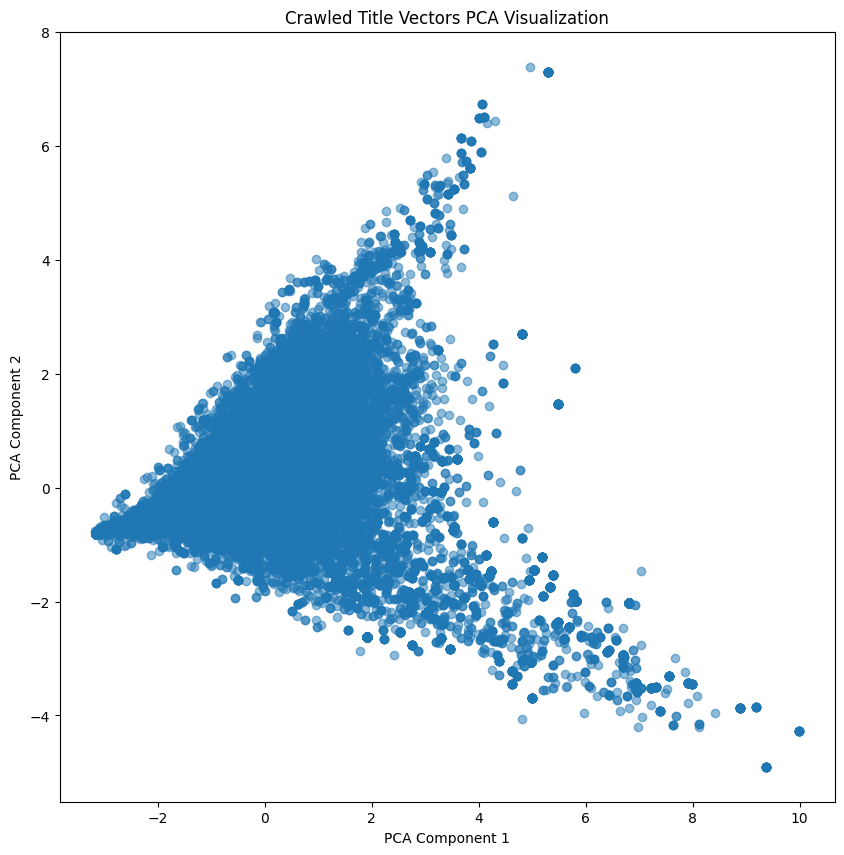

In [ ]:
import pandas as pd
import ast
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import nltk
from nltk.corpus import stopwords

# 필요 시 NLTK 불용어 다운로드
nltk.download('stopwords')

# CSV 파일 경로
csv_file_path = '/content/combined_final.csv'

# 데이터 로드
df = pd.read_csv(csv_file_path)

# 'tokens' 열이 문자열로 저장되었을 경우 리스트로 변환
df['tokens'] = df['tokens'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Word2Vec 모델 학습
model = Word2Vec(
    sentences=df['tokens'],
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    sg=0
)

# 각 문장의 벡터 생성
title_vectors = []
for tokens in df['tokens']:
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        sentence_vector = np.mean(vectors, axis=0)
    else:
        sentence_vector = np.zeros(model.vector_size)
    title_vectors.append(sentence_vector)

# DataFrame에 'vector' 열 추가
df['vector'] = title_vectors

# 벡터를 문자열로 변환하여 저장
df['vector'] = df['vector'].apply(lambda x: ','.join(map(str, x)))

# CSV 파일로 저장
vector_file_path = '/content/crawled_title_vectors.csv'
df.to_csv(vector_file_path, index=False)

print(f"벡터가 포함된 CSV 파일이 저장되었습니다: {vector_file_path}")

# (선택 사항) 벡터 시각화
# 벡터를 다시 리스트 형태로 변환
df['vector'] = df['vector'].apply(lambda x: list(map(float, x.split(','))))

# PCA를 사용하여 2차원으로 축소
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(df['vector'].tolist())

# 시각화
plt.figure(figsize=(10, 10))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], alpha=0.5)
plt.title('Crawled Title Vectors PCA Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [ ]:
exam=pd.read_csv('crawled_title_vectors.csv')
exam

,gender,age_group,job_type,city,duration,crawled_title,tokens,vector
0,2.0,1,4,울산,29,핸 즈 커피 디 인,"['핸', '즈', '커피', '디', '인']","0.035779953,0.4277932,0.16534421,0.19545978,0...."
1,1.0,1,1,대구,425,에펨 코리아 모바일 유머 축구 아프리카 TV 게임 풋볼매니저 에펨 펨코,"['에펨', '코리아', '모바일', '유머', '축구', '아프리카', 'TV',...","0.55586344,1.6297725,0.02723796,0.44311675,-0...."
2,2.0,1,3,제주,26,정용화 전현무 목발 로 사용 하는 혜리 Jung Yong Hwa Hyeri Jeon...,"['정용화', '전현무', '목발', '로', '사용', '하는', '혜리', 'J...","-0.024643065,0.2657169,0.048038974,0.003458401..."
3,1.0,1,1,대전,38,역정보 대전 교통 공사,"['역정보', '대전', '교통', '공사']","0.025048403,0.31458706,0.07775888,0.09889355,0..."
4,2.0,1,1,경기,83,아내 와 함께 떠난 딸 마지막 이 될 줄 몰랐다,"['아내', '와', '함께', '떠난', '딸', '마지막', '이', '될', ...","-0.36875376,0.57938516,0.4053534,0.029218918,0..."
...,...,...,...,...,...,...,...,...
54768,2.0,2,1,경기,38,속보 병역법 위반 축구 국가대표 출신 석현준 1 심 집행유예,"['속보', '병역법', '위반', '축구', '국가대표', '출신', '석현준',...","0.200406,0.2720056,0.090805024,0.18064955,0.05..."
54769,2.0,2,4,대구,61,우주 까지 가서 태양광 발전 을 하는 이유 YouTube 오디오 재생,"['우주', '가서', '태양광', '발전', '하는', '이유', 'YouTube...","0.44661415,0.8264992,-0.29055387,-0.16645442,0..."
54770,2.0,2,1,서울,36,어제 경기 노잼 답 게 시청률 망했네 골 때리는 그녀 들 마이너 갤러리,"['어제', '경기', '노잼', '답', '게', '시청률', '망했네', '골'...","-0.0765587,0.60366887,-0.052485585,0.1850391,0..."
54771,1.0,2,1,경기,40,아이비리그 대학교 YouTube,"['아이비리그', '대학교', 'YouTube']","0.55298585,0.4454538,-0.29339436,-0.042199094,..."
